- 1. Data Loading 
- 2. EDA 
- 3. Preprocessing 
- 4. Feature Engineering
- 5. Training

__Transaction Table__ <br>
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)<br>
* TransactionAMT: transaction payment amount in USD<br>
* ProductCD __(Categorical)__: product code, the product for each transaction<br>
* card1 - card6 __(Categorical)__: payment card information, such as card type, card category, issue bank, country, etc.<br>
* addr __(Categorical)__: address<br>
* dist: distance<br>
* P_ and (R__) emaildomain __(Categorical)__: purchaser and recipient email domain<br>
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.<br>
* D1-D15: timedelta, such as days between previous transaction, etc.<br>
* M1-M9 __(Categorical)__: match, such as names on card and address, etc.<br>
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.<br>

__Identity Table__<br>
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. <br>
Categorical Features:
* DeviceType
* DeviceInfo
* id12 - id38

# 1. Data Loading & Memory Reduce

In [60]:
#### basic
import pandas as pd
import numpy as np

#### Visulization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#### ML
import sklearn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

#### Others
import datetime
import os, warnings, random
warnings.filterwarnings('ignore')

## Load data

In [61]:
transaction_train = pd.read_csv('/Users/zhuyuwei/Desktop/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID')
transaction_test = pd.read_csv('/Users/zhuyuwei/Desktop/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID')
identity_train = pd.read_csv('/Users/zhuyuwei/Desktop/ieee-fraud-detection/train_identity.csv',index_col='TransactionID')
identity_test = pd.read_csv('/Users/zhuyuwei/Desktop/ieee-fraud-detection/test_identity.csv',index_col='TransactionID')

In [62]:
print('training set # for transaction: ' + str(len(transaction_train)))
transaction_train.head()

training set # for transaction: 590540


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
print('test set # for transaction: ' + str(len(transaction_test)))
transaction_test.head()

test set # for transaction: 506691


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
print('training set # for identity: ' + str(len(identity_train)))
identity_train.head(3)

training set # for identity: 144233


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


Then, merge identity table to the transcation table to enrich features 

In [65]:
train = pd.merge(transaction_train, identity_train, on='TransactionID', how='left',indicator = True)
test = pd.merge(transaction_test, identity_test, on='TransactionID', how='left',indicator = True)

In [66]:
train['_merge'].value_counts()

left_only     446307
both          144233
right_only         0
Name: _merge, dtype: int64

Not all transactions can be found corresponding indentity

In [67]:
print(len(train))
train.head()

590540


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,both


## Memory Reduction

In [68]:
#helper functions

## Seeder
# :seed to make all processes deterministic 
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

## Memory Reducer                                     
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [69]:
SEED = 42
seed_everything(SEED)

In [70]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 648.79 Mb (66.8% reduction)
Mem. usage decreased to 563.92 Mb (66.3% reduction)


In [107]:
#################################################################################
# Converting Strings to ints(or floats if nan in column) using frequency encoding
# We will be able to use these columns as category or as numerical feature
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']

for col in cat_cols:
    print('Encoding', col)
    temp_df = pd.concat([train[[col]], test[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train[col] = train[col].map(col_encoded)
    test[col]  = test[col].map(col_encoded)
    print(col_encoded)

Encoding id_12
{'NotFound': 243920, 'Found': 42220}
Encoding id_13
{52.0: 109760, 27.0: 73282, 49.0: 26365, 64.0: 14429, 33.0: 10048, 14.0: 6427, 20.0: 3804, 63.0: 2050, 62.0: 1752, 25.0: 1302, 18.0: 1218, 19.0: 1147, 41.0: 1086, 43.0: 907, 11.0: 890, 55.0: 781, 24.0: 531, 15.0: 520, 51.0: 349, 35.0: 317, 61.0: 108, 44.0: 87, 28.0: 77, 54.0: 67, 39.0: 45, 31.0: 38, 45.0: 26, 36.0: 25, 38.0: 22, 13.0: 21, 56.0: 19, 58.0: 17, 48.0: 12, 32.0: 10, 42.0: 9, 30.0: 9, 21.0: 8, 22.0: 5, 53.0: 4, 47.0: 3, 46.0: 3, 16.0: 3, 57.0: 3, 17.0: 3, 60.0: 3, 37.0: 3, 12.0: 2, 26.0: 2, 10.0: 1, 40.0: 1, 50.0: 1, 23.0: 1, 34.0: 1, 29.0: 1, 59.0: 1}
Encoding id_14
{-300.0: 83733, -360.0: 31196, -480.0: 24245, -420.0: 8751, -600.0: 1010, 60.0: 687, 0.0: 364, -240.0: 297, -180.0: 204, -540.0: 195, 480.0: 138, 540.0: 118, 600.0: 113, 120.0: 98, 180.0: 73, 420.0: 56, 240.0: 24, 330.0: 23, 270.0: 20, 300.0: 20, 720.0: 18, -210.0: 5, 570.0: 4, 360.0: 3, -120.0: 2, -660.0: 2, -720.0: 1, 660.0: 1}
Encoding id_15
{

{507.0: 34192, 222.0: 20843, 325.0: 15427, 533.0: 12483, 563.0: 12280, 595.0: 11814, 549.0: 10970, 214.0: 10945, 600.0: 10345, 333.0: 6979, 161.0: 6434, 500.0: 5364, 305.0: 5034, 597.0: 4831, 489.0: 4816, 127.0: 4768, 368.0: 4384, 256.0: 3940, 612.0: 3802, 535.0: 3705, 315.0: 3582, 391.0: 3504, 566.0: 3227, 401.0: 3111, 277.0: 3097, 177.0: 2794, 280.0: 2738, 561.0: 2704, 266.0: 2355, 497.0: 2315, 484.0: 2303, 225.0: 2268, 611.0: 2238, 146.0: 1883, 417.0: 1859, 122.0: 1843, 469.0: 1837, 472.0: 1835, 521.0: 1776, 278.0: 1656, 107.0: 1602, 565.0: 1473, 638.0: 1352, 299.0: 1342, 144.0: 1312, 100.0: 1115, 394.0: 1052, 178.0: 1043, 216.0: 956, 411.0: 942, 186.0: 858, 139.0: 845, 340.0: 830, 181.0: 815, 153.0: 771, 360.0: 724, 588.0: 603, 541.0: 579, 253.0: 574, 610.0: 569, 324.0: 558, 404.0: 558, 272.0: 539, 215.0: 427, 439.0: 426, 514.0: 425, 314.0: 420, 142.0: 393, 501.0: 389, 575.0: 381, 424.0: 377, 223.0: 374, 254.0: 275, 111.0: 270, 633.0: 254, 269.0: 242, 204.0: 230, 160.0: 226, 320.0:

{14.0: 9487, 41.0: 487, 33.0: 64, 43.0: 23, 24.0: 21, 27.0: 18, 21.0: 15, 36.0: 14, 39.0: 13, 17.0: 9, 22.0: 9, 15.0: 8, 35.0: 7, 12.0: 7, 31.0: 7, 20.0: 4, 26.0: 4, 16.0: 3, 28.0: 3, 40.0: 3, 42.0: 3, 32.0: 3, 13.0: 3, 44.0: 2, 18.0: 2, 19.0: 2, 38.0: 2, 10.0: 1, 11.0: 1, 25.0: 1, 37.0: 1, 30.0: 1, 34.0: 1, 29.0: 1, 23.0: 1}
Encoding id_23
{'IP_PROXY:TRANSPARENT': 7203, 'IP_PROXY:ANONYMOUS': 2010, 'IP_PROXY:HIDDEN': 1018}
Encoding id_24
{11.0: 5666, 15.0: 2948, 16.0: 315, 21.0: 222, 24.0: 141, 18.0: 104, 12.0: 26, 19.0: 24, 26.0: 14, 17.0: 9, 25.0: 9, 20.0: 4, 14.0: 1, 13.0: 1, 22.0: 1, 23.0: 1, 10.0: 1}
Encoding id_25
{321.0: 5233, 205.0: 569, 426.0: 469, 442.0: 188, 501.0: 151, 371.0: 132, 509.0: 115, 524.0: 114, 123.0: 97, 126.0: 64, 479.0: 59, 236.0: 56, 463.0: 55, 143.0: 54, 432.0: 53, 385.0: 51, 505.0: 51, 247.0: 48, 472.0: 45, 239.0: 45, 486.0: 43, 356.0: 38, 270.0: 37, 511.0: 36, 359.0: 36, 250.0: 36, 516.0: 35, 481.0: 31, 170.0: 29, 264.0: 27, 258.0: 26, 355.0: 25, 110.0: 25,

{'mobile safari 11.0': 23655, 'chrome 63.0': 22168, 'chrome 70.0': 16054, 'ie 11.0 for desktop': 14203, 'mobile safari 12.0': 13098, 'mobile safari generic': 11474, 'chrome 71.0': 9489, 'chrome 69.0': 8294, 'safari generic': 8195, 'chrome 70.0 for android': 7624, 'chrome 62.0': 7283, 'chrome 65.0': 7114, 'chrome 64.0': 6822, 'chrome 68.0': 6449, 'chrome 67.0': 6155, 'chrome 69.0 for android': 6022, 'chrome 63.0 for android': 5993, 'chrome 71.0 for android': 5029, 'edge 17.0': 4945, 'chrome generic': 4778, 'chrome 66.0': 4608, 'edge 16.0': 4592, 'mobile safari 10.0': 3933, 'chrome 64.0 for android': 3735, 'chrome 65.0 for android': 3659, 'chrome 67.0 for android': 3637, 'safari 12.0': 3550, 'chrome 68.0 for android': 3520, 'safari 11.0': 3447, 'firefox 57.0': 3331, 'chrome 66.0 for android': 2941, 'chrome 62.0 for android': 2240, 'firefox 63.0': 1899, 'edge 15.0': 1725, 'samsung browser 7.4': 1369, 'ie 11.0 for tablet': 1330, 'firefox 61.0': 1321, 'firefox 64.0': 1251, 'chrome generic f

{'match_status:2': 132185, 'match_status:1': 17377, 'match_status:0': 415, 'match_status:-1': 3}
Encoding id_35
{'T': 149464, 'F': 128498}
Encoding id_36
{'F': 267353, 'T': 10609}
Encoding id_37
{'T': 215149, 'F': 62813}
Encoding id_38
{'F': 168980, 'T': 108982}
Encoding DeviceType
{'desktop': 159568, 'mobile': 118173}
Encoding DeviceInfo
{'Windows': 92710, 'iOS Device': 38502, 'MacOS': 23722, 'Trident/7.0': 12330, 'rv:11.0': 2650, 'SM-G532M Build/MMB29T': 980, 'rv:57.0': 968, 'SM-J700M Build/MMB29K': 829, 'SM-G610M Build/MMB29K': 804, 'SM-G531H Build/LMY48B': 682, 'rv:63.0': 474, 'ALE-L23 Build/HuaweiALE-L23': 458, 'SM-G935F Build/NRD90M': 450, 'SAMSUNG': 445, 'rv:61.0': 421, 'rv:52.0': 378, 'rv:59.0': 376, 'rv:62.0': 335, 'SM-G955U Build/NRD90M': 334, 'Moto G (4) Build/NPJ25.93-14.7': 326, 'SM-J730GM Build/NRD90M': 319, 'ANE-LX3': 315, 'rv:64.0': 310, 'SM-G950U Build/NRD90M': 308, 'LG-M700 Build/NMF26X': 300, 'SAMSUNG SM-G532M Build/MMB29T': 299, 'SM-G930V Build/NRD90M': 298, 'moto g

{800657: 800657, 137785: 137785, 73346: 73346, 62397: 62397, 23046: 23046}
Encoding card4
{719649.0: 719649, 347386.0: 347386, 16009.0: 16009, 9524.0: 9524}
Encoding card6
{824959.0: 824959, 267648.0: 267648, 30.0: 30, 16.0: 16}
Encoding M4
{357789.0: 357789, 122947.0: 122947, 97306.0: 97306}
Encoding P_emaildomain
{435803.0: 435803, 182784.0: 182784, 85649.0: 85649, 71062.0: 71062, 52337.0: 52337, 14474.0: 14474, 12316.0: 12316, 9934.0: 9934, 7647.0: 7647, 7480.0: 7480, 5767.0: 5767, 5720.0: 5720, 5011.0: 5011, 4075.0: 4075, 3437.0: 3437, 2827.0: 2827, 2713.0: 2713, 2657.0: 2657, 1937.0: 1937, 1470.0: 1470, 1443.0: 1443, 1156.0: 1156, 1105.0: 1105, 993.0: 993, 979.0: 979, 863.0: 863, 862.0: 862, 674.0: 674, 627.0: 627, 594.0: 594, 583.0: 583, 574.0: 574, 552.0: 552, 518.0: 518, 468.0: 468, 464.0: 464, 439.0: 439, 397.0: 397, 387.0: 387, 386.0: 386, 362.0: 362, 344.0: 344, 334.0: 334, 323.0: 323, 319.0: 319, 318.0: 318, 311.0: 311, 303.0: 303, 298.0: 298, 277.0: 277, 272.0: 272, 159.0:

{321.0: 91731, 111.0: 82537, 555.0: 80404, 490.0: 70496, 583.0: 41503, 170.0: 33411, 545.0: 31894, 194.0: 31511, 514.0: 27225, 360.0: 26532, 174.0: 21406, 512.0: 19884, 408.0: 17160, 361.0: 14420, 215.0: 13801, 100.0: 13651, 399.0: 13458, 225.0: 13274, 553.0: 12202, 375.0: 12157, 476.0: 11690, 567.0: 11287, 268.0: 10651, 481.0: 10151, 543.0: 9968, 130.0: 8141, 298.0: 8069, 327.0: 7935, 500.0: 7475, 103.0: 6961, 204.0: 6731, 562.0: 6499, 206.0: 6342, 310.0: 6207, 161.0: 6176, 269.0: 5810, 404.0: 5593, 445.0: 5391, 494.0: 5373, 455.0: 5269, 390.0: 5097, 264.0: 4983, 250.0: 4887, 453.0: 4715, 122.0: 4451, 417.0: 4216, 369.0: 3626, 532.0: 3610, 142.0: 3609, 393.0: 3528, 181.0: 3513, 418.0: 3433, 452.0: 3014, 558.0: 2669, 177.0: 2618, 296.0: 2516, 127.0: 2323, 158.0: 2319, 470.0: 2149, 548.0: 2059, 513.0: 2048, 302.0: 2035, 517.0: 2028, 383.0: 2024, 346.0: 1898, 276.0: 1801, 554.0: 1796, 396.0: 1791, 216.0: 1758, 428.0: 1746, 579.0: 1739, 343.0: 1731, 420.0: 1627, 254.0: 1575, 247.0: 1518, 

{299.0: 85045, 204.0: 77069, 325.0: 76902, 264.0: 72580, 330.0: 48387, 315.0: 43035, 441.0: 38890, 272.0: 35929, 123.0: 28700, 126.0: 28198, 337.0: 28081, 191.0: 27910, 184.0: 27205, 181.0: 25410, 143.0: 18431, 476.0: 17455, 310.0: 16127, 327.0: 15904, 387.0: 15737, 472.0: 15704, 512.0: 15251, 433.0: 14542, 231.0: 13532, 485.0: 12540, 269.0: 12156, 205.0: 11025, 225.0: 9886, 220.0: 9371, 251.0: 9146, 226.0: 8853, 494.0: 8726, 177.0: 8628, 498.0: 8539, 203.0: 7284, 420.0: 7107, 110.0: 6212, 436.0: 5882, 469.0: 5745, 170.0: 3810, 444.0: 3699, 324.0: 3692, 343.0: 3207, 384.0: 3063, 194.0: 3060, 122.0: 2898, 428.0: 2843, 158.0: 2633, 308.0: 2206, 284.0: 1911, 253.0: 1876, 492.0: 1824, 448.0: 1784, 502.0: 1565, 465.0: 1189, 296.0: 789, 130.0: 736, 536.0: 595, 161.0: 453, 157.0: 342, 511.0: 297, 348.0: 206, 356.0: 177, 418.0: 161, 375.0: 146, 483.0: 142, 431.0: 138, 148.0: 132, 216.0: 122, 242.0: 117, 391.0: 115, 239.0: 115, 453.0: 112, 254.0: 103, 520.0: 97, 258.0: 90, 508.0: 90, 432.0: 82,

KeyError: "None of [Index(['P_emaildomain_1'], dtype='object')] are in the [columns]"

In [72]:
# M columns
#################################################################################
# Converting Strings to ints(or floats if nan in column)

for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train[col] = train[col].map({'T':1, 'F':0})
    test[col]  = test[col].map({'T':1, 'F':0})

for col in ['M4']:
    print('Encoding', col)
    temp_df = pd.concat([train[[col]], test[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train[col] = train[col].map(col_encoded)
    test[col]  = test[col].map(col_encoded)
    print(col_encoded)

Encoding M4
{'M0': 357789, 'M2': 122947, 'M1': 97306}


In [108]:
#final minification
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 587.96 Mb (17.7% reduction)
Mem. usage decreased to 511.73 Mb (17.5% reduction)


In [109]:
#export
train.to_pickle('train_mini.pkl')
test.to_pickle('test_mini.pkl')

# 2. EDA

Some interesting pattern to find:
1.  How is the distribution of rate of fraud by day?

In [102]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT_new'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT_new'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

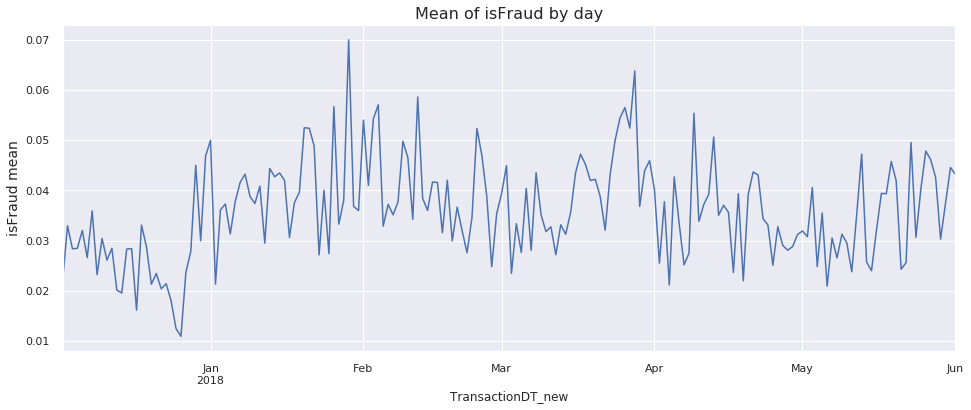

In [103]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT_new').resample('D').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('Mean of isFraud by day', fontsize=16);

# 3. Preprocessing
## Drop columns with too many NaN

In [75]:
for column in train:
    total = len(train)
    print('{0} : {1}'.format(column, train[column].isnull().sum()/total))

isFraud : 0.0
TransactionDT : 0.0
TransactionAmt : 0.0
ProductCD : 0.0
card1 : 0.0
card2 : 0.015126833068039422
card3 : 0.0026501168422122124
card4 : 0.00267043722694483
card5 : 0.007212043214684865
card6 : 0.0026602770345785214
addr1 : 0.1112642666034477
addr2 : 0.1112642666034477
dist1 : 0.596523520845328
dist2 : 0.9362837403054831
P_emaildomain : 0.1599485216920107
R_emaildomain : 0.7675161716395164
C1 : 0.0
C2 : 0.0
C3 : 0.0
C4 : 0.0
C5 : 0.0
C6 : 0.0
C7 : 0.0
C8 : 0.0
C9 : 0.0
C10 : 0.0
C11 : 0.0
C12 : 0.0
C13 : 0.0
C14 : 0.0
D1 : 0.0021488806854743116
D2 : 0.4754919226470688
D3 : 0.44514850814508755
D4 : 0.2860466691502693
D5 : 0.524674027161581
D6 : 0.8760676668811597
D7 : 0.9340992989467267
D8 : 0.8731229044603245
D9 : 0.8731229044603245
D10 : 0.1287330240119213
D11 : 0.47293494090154775
D12 : 0.8904104717715988
D13 : 0.8950926270870728
D14 : 0.8946946862193924
D15 : 0.1509008703898127
M1 : 0.4590713584177194
M2 : 0.4590713584177194
M3 : 0.4590713584177194
M4 : 0.47658753005723

V300 : 0.0021488806854743116
V301 : 0.0021488806854743116
V302 : 2.0320384732617603e-05
V303 : 2.0320384732617603e-05
V304 : 2.0320384732617603e-05
V305 : 2.0320384732617603e-05
V306 : 2.0320384732617603e-05
V307 : 2.0320384732617603e-05
V308 : 2.0320384732617603e-05
V309 : 2.0320384732617603e-05
V310 : 2.0320384732617603e-05
V311 : 2.0320384732617603e-05
V312 : 2.0320384732617603e-05
V313 : 0.0021488806854743116
V314 : 0.0021488806854743116
V315 : 0.0021488806854743116
V316 : 2.0320384732617603e-05
V317 : 2.0320384732617603e-05
V318 : 2.0320384732617603e-05
V319 : 2.0320384732617603e-05
V320 : 2.0320384732617603e-05
V321 : 2.0320384732617603e-05
V322 : 0.8605496664070174
V323 : 0.8605496664070174
V324 : 0.8605496664070174
V325 : 0.8605496664070174
V326 : 0.8605496664070174
V327 : 0.8605496664070174
V328 : 0.8605496664070174
V329 : 0.8605496664070174
V330 : 0.8605496664070174
V331 : 0.8605496664070174
V332 : 0.8605496664070174
V333 : 0.8605496664070174
V334 : 0.8605496664070174
V335 : 

In [110]:
def drop_sparse_column(threshold, df_train, df_test):
    new_train = df_train.copy()
    new_test = df_test.copy()
    total = len(df_train)
    for column in df_train:
        percent = df_train[column].isnull().sum()/total
        if percent > threshold:
            new_train = new_train.drop(columns = [column])
            new_test = new_test.drop(columns = [column])
    return new_train, new_test

In [111]:
new_train, new_test = drop_sparse_column(0.9, train,test)

In [112]:
new_train.head(3)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge,TransactionDT_new
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,800657,56,NaN,956845.0,9524.0,309.0,267648.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:00:00
2987001,0,86401,29.0,800657,1338,5593.0,956845.0,347386.0,49491.0,267648.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:00:01
2987002,0,86469,59.0,800657,1794,70496.0,956845.0,719649.0,102930.0,824959.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:01:09


## Drop single value dominant columns

In [113]:
def drop_single_dominant(threshold, df_train, df_test):
    new_train = df_train.copy()
    isfraud = new_train['isFraud']
    new_train = new_train.drop(columns = ['isFraud'])
    new_test = df_test.copy()
    for column in new_train:
        if train[column].value_counts(dropna = False, normalize = True).values[0] > threshold:
            new_train = new_train.drop(columns = [column])
            new_test = new_test.drop(columns = [column])
    new_train['isFraud'] = isfraud
    return new_train, new_test

In [114]:
new_train, new_test = drop_single_dominant(0.9, new_train, new_test)

In [115]:
new_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge,TransactionDT_new,isFraud
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,800657,56,NaN,956845.0,9524.0,309.0,267648.0,43035.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:00:00,0
2987001,86401,29.0,800657,1338,5593.0,956845.0,347386.0,49491.0,267648.0,76902.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:00:01,0
2987002,86469,59.0,800657,1794,70496.0,956845.0,719649.0,102930.0,824959.0,48387.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:01:09,0
2987003,86499,50.0,800657,7635,11287.0,956845.0,347386.0,47061.0,824959.0,17455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:01:39,0
2987004,86506,50.0,62397,30,27225.0,956845.0,347386.0,49491.0,267648.0,7107.0,...,132185.0,149464.0,267353.0,215149.0,108982.0,118173.0,9.0,both,2017-12-02 00:01:46,0


## Drop one value columns

In [116]:
def drop_one_value(df_train, df_test):
    new_train = df_train.copy()
    new_test = df_test.copy()
    for column in new_train:
        if train[column].nunique() <= 1:
            new_train = new_train.drop(columns = [column])
            new_test = new_test.drop(columns = [column])
    return new_train, new_test

In [117]:
new_train, new_test = drop_one_value(new_train, new_test)

In [118]:
new_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge,TransactionDT_new,isFraud
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,800657,56,NaN,956845.0,9524.0,309.0,267648.0,43035.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:00:00,0
2987001,86401,29.0,800657,1338,5593.0,956845.0,347386.0,49491.0,267648.0,76902.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:00:01,0
2987002,86469,59.0,800657,1794,70496.0,956845.0,719649.0,102930.0,824959.0,48387.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:01:09,0
2987003,86499,50.0,800657,7635,11287.0,956845.0,347386.0,47061.0,824959.0,17455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:01:39,0
2987004,86506,50.0,62397,30,27225.0,956845.0,347386.0,49491.0,267648.0,7107.0,...,132185.0,149464.0,267353.0,215149.0,108982.0,118173.0,9.0,both,2017-12-02 00:01:46,0


## Drop high correlated columns

In [123]:
def drop_high_correlation(threshold, df_train, df_test):
    new_train = df_train.copy()
    new_test = df_test.copy()
    # Create correlation matrix
    corr_matrix = new_train.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    new_train = new_train.drop(new_train[to_drop],axis = 1)
    new_test = new_test.drop(new_test[to_drop],axis = 1)
    return new_train,new_test

In [124]:
new_train, new_test = drop_high_correlation(0.95, new_train, new_test)

In [125]:
new_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33,id_34,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge,TransactionDT_new,isFraud
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,800657,56,NaN,956845.0,9524.0,309.0,267648.0,43035.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:00:00,0
2987001,86401,29.0,800657,1338,5593.0,956845.0,347386.0,49491.0,267648.0,76902.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:00:01,0
2987002,86469,59.0,800657,1794,70496.0,956845.0,719649.0,102930.0,824959.0,48387.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:01:09,0
2987003,86499,50.0,800657,7635,11287.0,956845.0,347386.0,47061.0,824959.0,17455.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,2017-12-02 00:01:39,0
2987004,86506,50.0,62397,30,27225.0,956845.0,347386.0,49491.0,267648.0,7107.0,...,1430.0,132185.0,267353.0,215149.0,108982.0,118173.0,9.0,both,2017-12-02 00:01:46,0


# 4. Feature Engineering

Several ideas:
- use PCA to reduce # of columns (for groups, e.g. card 1-6, id, etc.) https://www.kaggle.com/kabure/almost-complete-feature-engineering-ieee-data#V-Features
- aggregation https://www.kaggle.com/artgor/eda-and-models#Feature-engineering; https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again?scriptVersionId=18889353
- focus on important features https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
